# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = mchmc(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MCHMC.Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [9]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 8.709047172010376
eps: 0.125 --> VarE: 23.994589748919807
eps: 0.0625 --> VarE: 5.039094985619223
eps: 0.03125 --> VarE: 2.0415798595158874
eps: 0.015625 --> VarE: 0.7855387835278662


[ Info: Found eps: 0.015625 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.1498329997666189


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.24349558819290018, 0.7015082892534154, 0.0, 10.695690774771087]
 [0.24349558819290018, 0.7015082892534154, 1.826300322963755, 12.526574425201536]
 [0.25202191298758625, 0.7146018911450082, 1.863597797990007, 10.707064284302785]
 [0.2462957687206517, 0.7000639443561988, -4.32567714698253, 9.469626681344495]
 [0.23077978110006236, 0.6982214587639299, -0.00045643297698028107, 11.469655227996551]
 [0.23703812036538197, 0.7125383653655726, 5.068688745254608, 12.91933100489529]
 [0.2357073457519575, 0.7281065914664572, 4.055751252107218, 14.451878276129944]
 [0.24687845348487727, 0.7390311956707064, 4.321508929196034, 15.769733262881797]
 [0.25250624908311187, 0.7536074963572487, 3.6343082213392854, 16.81718917706702]
 [0.255600442211901, 0.7689230634013301, 2.005316519987197, 16.718199502900788]
 [0.2413422370320465, 0.7753140109092643, -0.24240751470432542, 16.57426855494074]
 [0.2274504197640403, 0.7824664956518083, 0.4748072625031803, 17.356787103150477]
 [

In [10]:
#plt.plot(samples_mchmc.E[8000:end])

In [11]:
#mean(samples_mchmc.E[8000:end])

In [12]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [13]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

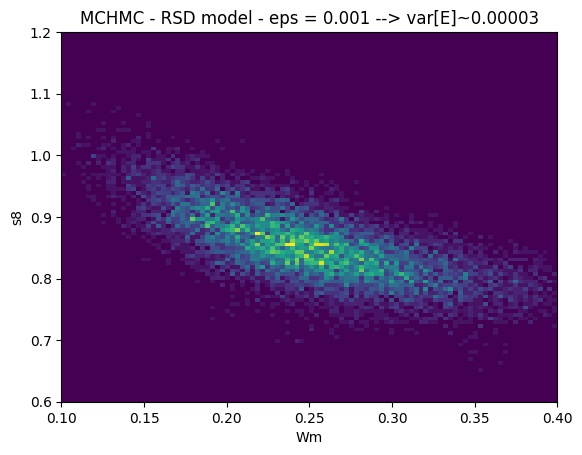

In [14]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [22]:
samples = sample(
    stat_model, mchmc(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 349.3764339594904
eps: 0.125 --> VarE: 216.66519753390503
eps: 0.0625 --> VarE: 9.071224821247336
eps: 0.03125 --> VarE: 3.3749008567608505
eps: 0.015625 --> VarE: 1.5243742599387968
samples: 100--> ESS: 0.04483486519138105


[ Info: Found eps: 0.015625 ✅
[ Info: Tuning L ⏳


samples: 243--> ESS: 0.041882227488730654


[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.76 seconds
Compute duration  = 1.76 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2527    0.0586     0.0006    0.0018   683.1986    0.9999     ⋯
          σ8    0.8519    0.0565     0.0006    0.0017   701.5853    0.9999     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1513    0.2108    0.2486    0.2898    0.3805
          σ8    0.7527    0.8132    0.8476    0.8869    0.9697


In [23]:
new_samples = sample(stat_model, mchmc(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.26 seconds
Compute duration  = 1.26 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2495    0.0602     0.0006    0.0018   653.7546    1.0015     ⋯
          σ8    0.8570    0.0596     0.0006    0.0018   656.2351    1.0019     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1430    0.2066    0.2455    0.2885    0.3781
          σ8    0.7575    0.8157    0.8519    0.8930    0.9853


In [17]:
#StatsPlots.plot(new_samples)

## NUTS

In [28]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.46 seconds
Compute duration  = 2.46 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2529    0.0591     0.0006    0.0011   2782.7588    0.9999    ⋯
          σ8    0.8529    0.0553     0.0006    0.0012   2291.9041    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [29]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.287093  0.867587  17.958   3.0  1.0  …  1.0  0.0  0.660208  0.660208
 0.172582  0.864061  17.2658  7.0  1.0     2.0  0.0  0.660208  0.660208
 0.20796   0.964825  16.2237  7.0  1.0     2.0  0.0  0.660208  0.660208
 0.204067  0.96482   16.3926  1.0  1.0     1.0  0.0  0.660208  0.660208
 0.197694  0.970248  16.355   3.0  1.0     2.0  0.0  0.660208  0.660208
 0.14873   0.910243  16.8453  3.0  1.0  …  2.0  0.0  0.660208  0.660208
 0.160976  0.993368  16.4003  3.0  1.0     1.0  0.0  0.660208  0.660208
 0.184545  0.884184  18.2677  7.0  1.0     2.0  0.0  0.660208  0.660208
 0.167109  0.879238  17.3634  3.0  1.0     2.0  0.0  0.660208  

In [26]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

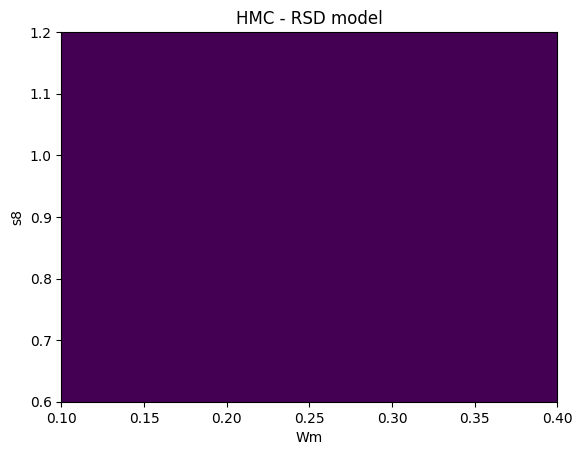

In [27]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");